In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import os

In [12]:
# change to your working directory
os.chdir(r'C:\Users\klilasulin\Dropbox\brain on a chip\Human brain organoids article\EMChip_paper_analysis_git')
os.getcwd()


'C:\\Users\\klilasulin\\Dropbox\\brain on a chip\\Human brain organoids article\\EMChip_paper_analysis_git'

For this analysis, the computed FFT fractions are provided in the data folder. The calculation steps are described below.

In [2]:


def calculate_fft_area(freqs, amps, band_min, band_max, y_min=0.0):
    """
    Calculate a simple 'area' for frequencies in [band_min, band_max].
    The area is computed as the sum of (amp - y_min) * freq_resolution
    for all frequencies in the specified band, where amp > y_min.
    """
    if len(freqs) < 2:
        return 0.0  # Edge case: not enough frequency points

    # Approximate frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Boolean mask for the desired band
    mask = (freqs >= band_min) & (freqs < band_max)

    # Sum up the 'area'
    area_val = 0.0
    for amp in amps[mask]:
        if amp > y_min:
            area_val += (amp - y_min) * freq_res

    return area_val





In [5]:
def calc_fft_area_lfp(dfs, chan, low, high, sampling_rate, band_ranges):
  area_df = pd.DataFrame()
  for df_i in range(len(dfs)):
    # ------------------------- (1) FFT  -------------------------
    data = dfs[df_i][chan].values
    # Calculate the FFT
    fft_data = np.fft.rfft(data)
    fft_freq = np.fft.rfftfreq(len(data), 1.0 / sampling_rate)
    mask = (fft_freq > low) & (fft_freq <= high)
    # Masked data for plotting
    masked_freqs_lfp = fft_freq[mask]
    masked_fft_lfp = np.abs(fft_data[mask])
    abs_fft = np.abs(fft_data)

    band_areas = {}
    for i in range(len(band_ranges) - 1):
        band_min = band_ranges[i]
        band_max = band_ranges[i + 1]
        area_val = calculate_fft_area(fft_freq, abs_fft, band_min, band_max)
        band_label = f"{band_min}-{band_max} Hz"
        band_areas[band_label] = area_val
        # add band to df in row df_i
        area_df.loc[df_i, band_label] = area_val

  return area_df


In [7]:
def process_table(fft_df, signal_type):
    """
    Compute FFT band fractions for LFP or O₂ signals.

    This function takes a DataFrame containing pre-computed FFT band areas
    (e.g., low_delta, high_delta, theta, alpha, beta) and calculates,
    for each sample, the fractional contribution of each frequency band
    to the total FFT area across the analyzed frequency range.

    Fraction is defined as:
        band_area / total_area

    Parameters
    ----------
    fft_df : pandas.DataFrame
        DataFrame containing FFT band areas computed previously.
    signal_type : str
        'lfp' for LFP data (uses five bands),
        'o2'  for O₂ data (uses two bands).

    Returns
    -------
    pandas.DataFrame
        The input DataFrame with added columns:
        - 'total_area'
        - '{band}_fraction' for each relevant frequency band
    """

    # ------------ calculate total area ----------------
    if signal_type == 'lfp':
        fft_df['total_area'] = (
            fft_df['low_delta']
            + fft_df['high_delta']
            + fft_df['theta']
            + fft_df['alpha']
            + fft_df['beta']
        )

        for band in ['low_delta', 'high_delta', 'theta', 'alpha', 'beta']:
            fft_df[f'{band}_fraction'] = fft_df[band] / fft_df['total_area']

    elif signal_type == 'o2':
        fft_df['total_area'] = fft_df['low_delta'] + fft_df['high_delta']

        for band in ['low_delta', 'high_delta']:
            fft_df[f'{band}_fraction'] = fft_df[band] / fft_df['total_area']

    return fft_df


Organoid Activity Filtering & FFT Fractions

We first compute band thresholds from stable “medium” recordings:

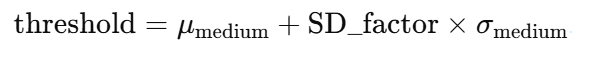
	​


Any organoid with at least one band above this threshold is considered active.


This removes non-active organoids and allows consistent comparison to adult cortex spectral patterns.

All adult EEG samples considered as active without filtering 

In [8]:
def calculate_threshold(df, exp_list, bands, sd_factor):
    """
    Calculate band-specific thresholds based on stable 'medium' recordings.

    Threshold for each band is computed as:
        threshold = mean_medium + sd_factor * std_medium

    Parameters
    ----------
    df : pandas.DataFrame
        FFT area table containing medium and baseline recordings.
    exp_list : list of str
        Experiment names considered stable under 'medium' conditions.
    bands : list of str
        List of FFT bands to compute thresholds for.
    sd_factor : float
        Multiplier applied to the standard deviation.

    Returns
    -------
    dict
        Dictionary mapping each band to its computed threshold.
    """

    threshold_dict = {}
    filtered_df = df[df['Exp_name'].isin(exp_list)]

    for band in bands:
        mean_medium = filtered_df.loc[filtered_df['cond_name'] == 'medium', band].mean()
        std_medium  = filtered_df.loc[filtered_df['cond_name'] == 'medium', band].std()
        threshold_dict[band] = mean_medium + sd_factor * std_medium

    return threshold_dict


In [9]:
def create_filtered_table(table_df, baseline_df, fft_area_adult, binary_output=False):
    """
    Filter organoids based on activity and compute band fractions or binary scores.

    Steps:
    1. Identify active organoids (any band with value == 1 in table_df)
    2. Compute adult reference FFT fraction profile
    3. For each organoid in baseline_df:
         - If binary_output is False, return raw fractions
         - If True, return 1 if above (adult_mean - 1*SD), else 0

    Parameters
    ----------
    table_df : pandas.DataFrame
        Binary activation table (bands x organoids or transposed).
    baseline_df : pandas.DataFrame
        DataFrame with FFT fractions for baseline condition.
    fft_area_adult : pandas.DataFrame
        FFT fraction values for adult cortex samples.
    binary_output : bool, optional
        If True: output 0/1 per band.
        If False: output continuous fractions.

    Returns
    -------
    pandas.DataFrame
        Filtered table containing only active organoids and their band values.
    """

    # --- Identify active organoids ---
    active_organoids = [
        exp for exp in table_df.index
        if table_df.loc[exp].max() == 1
    ]
    active_organoids = list(set(active_organoids))

    # --- Compute adult mean and SD ---
    adult_mean = fft_area_adult.mean()
    adult_sd   = fft_area_adult.std()

    bands_fraction = [
        'low_delta fraction', 'high_delta fraction',
        'theta fraction', 'alpha fraction', 'beta fraction'
    ]

    out_df = pd.DataFrame()

    for _, row in baseline_df.iterrows():
        exp = row['Exp_name']
        if exp not in active_organoids:
            continue

        row_dict = {}

        for band in bands_fraction:
            if not binary_output:
                row_dict[band] = row[band]
            else:
                row_dict[band] = int(row[band] > (adult_mean[band] - adult_sd[band]))

        out_df = pd.concat([out_df, pd.DataFrame(row_dict, index=[exp])])

    return out_df


In [13]:
# Load the fraction data 

fractions_df = pd.read_excel('data/Brain_waves_analysis/FFT_Fractions_comb_for_heatmap.xlsx', index_col=0)
fractions_df

,low_delta,high_delta,theta,alpha,beta,age
Exp_B1,0.652832,0.094300,0.070306,0.063438,0.119124,71.0
Exp_D1,0.411083,0.327934,0.176240,0.041229,0.043515,73.0
Exp_D2,0.411455,0.254625,0.235841,0.036445,0.061633,73.0
Exp_B4,0.261736,0.244401,0.275734,0.109950,0.108179,83.0
Exp_B7,0.466183,0.233937,0.161654,0.063996,0.074231,90.0
Exp_B9,0.693487,0.144620,0.068099,0.034843,0.058951,92.0
Exp_B13,0.400443,0.215325,0.168478,0.087334,0.128421,97.0
Exp_B11,0.485350,0.220405,0.165671,0.068781,0.059793,97.0
Exp_B14,0.291599,0.183199,0.157415,0.125827,0.241959,98.0
Exp_B17,0.330908,0.221912,0.202020,0.111983,0.133177,99.0


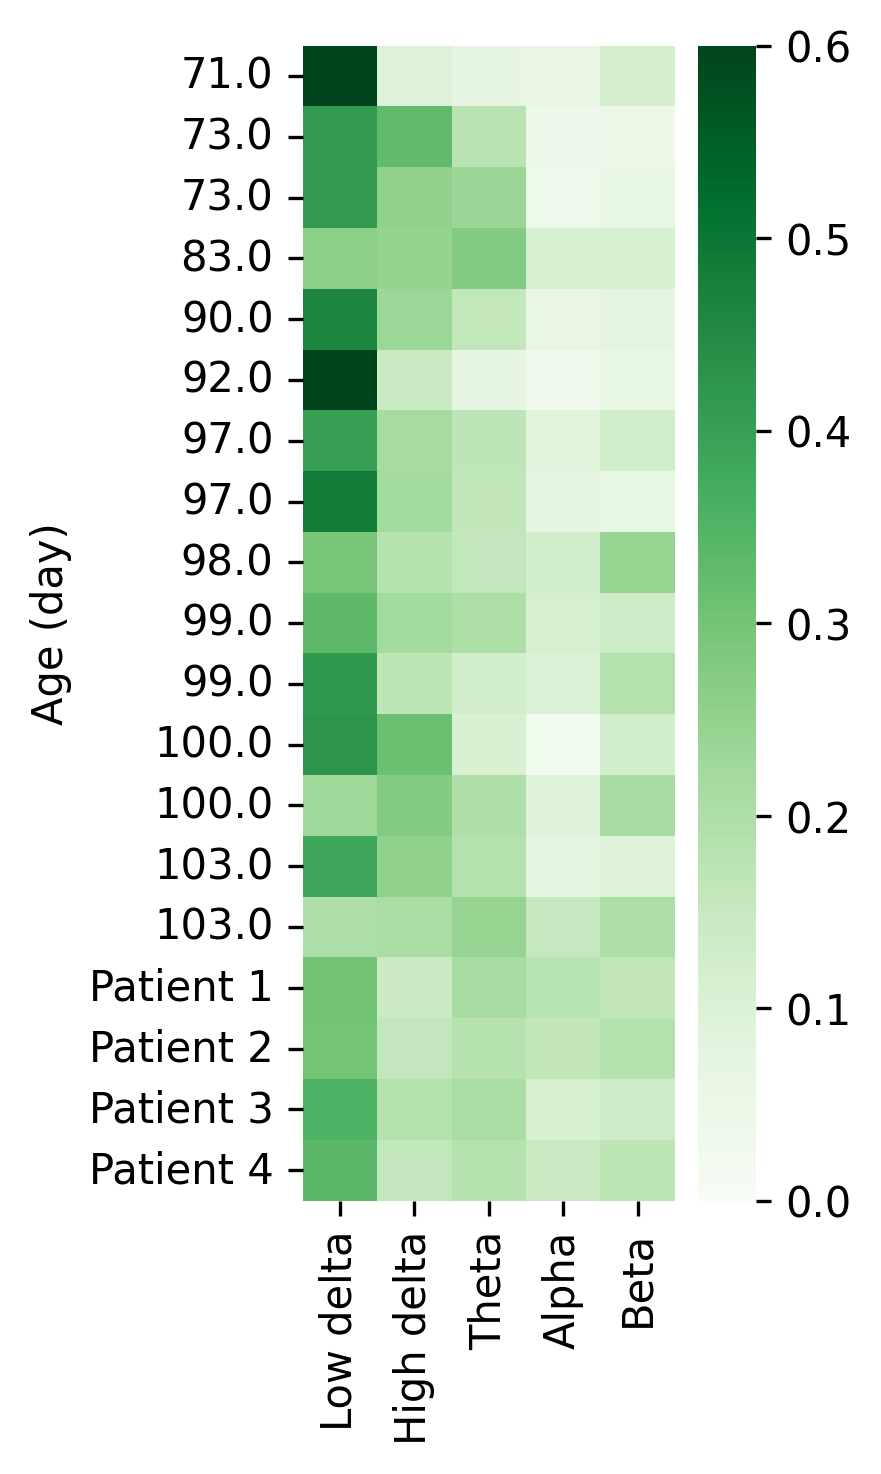

In [ ]:

fft_perc_comb_to_heatmap = fractions_df.drop(columns=['age'])
heat_map_y_axis = fractions_df['age'].dropna().tolist() + ['Patient 1', 'Patient 2', 'Patient 3', 'Patient 4' ]
plt.figure(figsize=(2, 5), dpi=300)
# active_bands_to_heatmap = active_bands_comb[bands_to_plot]
bands_ticks = ['Low delta', 'High delta', 'Theta', 'Alpha', 'Beta']
sns.heatmap(fft_perc_comb_to_heatmap, annot=False, cmap=sns.color_palette("Greens", as_cmap=True), vmin=0, vmax=0.6, yticklabels=heat_map_y_axis, xticklabels=bands_ticks  )
plt.xticks(rotation=90)  # Rotate x-axis labels to 45 degrees
plt.ylabel('Age (day)')
plt.show()


plt.show()


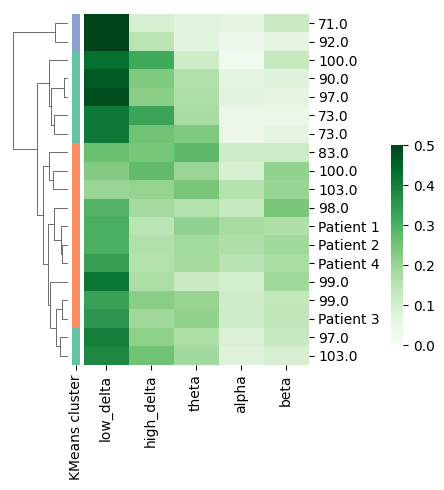

In [22]:

from sklearn.cluster import KMeans

# --- Parameters ---
n_clusters = 3
column_order = ['low_delta', 'high_delta', 'theta','alpha', 'beta']
fontsize = 10
x_rotation = 90
vmin_val = 0.0
vmax_val = 0.5
figsize = (4, 5)
dpi_val = 300

# ---  data ---
df = fft_perc_comb_to_heatmap.copy()
df = df.rename(columns={df.columns[0]: "Sample"})
df.index = heat_map_y_axis
df.columns = ['low_delta', 'high_delta', 'theta','alpha', 'beta']
# --- Extract features in desired order ---
X = df[column_order]

# --- KMeans Clustering on original values ---
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["KMeans cluster"] = kmeans.fit_predict(X)

# --- Row colors (cluster only) ---
cluster_palette = sns.color_palette("Set2", n_clusters)
lut_kmeans = dict(zip(range(n_clusters), cluster_palette))
row_colors = df["KMeans cluster"].map(lut_kmeans)

# --- Plot heatmap ---
g = sns.clustermap(
    data=X,
    row_cluster=True, col_cluster=False,  # cluster rows only
    row_colors=row_colors,
    cmap="Greens",
    vmin=vmin_val, vmax=vmax_val,
    figsize=figsize,
    dendrogram_ratio=(0.2, 0.01),  # reduce space for top dendrogram
)
g.cax.set_position([.99, .3, .03, .4])

# --- Adjust formatting ---
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=x_rotation, fontsize=fontsize)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=fontsize)
g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

plt.show()
